## Курсовой проект для курса "Python для Data Science"
### Подключение библиотек и скриптов

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

In [1]:
import numpy as np
import pandas as pd
import random
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams.update({'font.size': 14})

import warnings
warnings.filterwarnings('ignore')

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):

    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(10,5))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [3]:
TRAIN_DATASET_PATH = './project_task/train.csv'
TEST_DATASET_PATH = './project_task/test.csv'
MODEL_FILE_PATH = './project_task/model.pkl'

# Шаг 1. Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [4]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail(n=5)

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
9995    77          32    2.0  50.401785   30.476203            5.0      6   
9996  6159          18    1.0  41.521546   20.539216            9.0     13   
9997  5123          27    1.0  47.939008         NaN            1.0     12   
9998  5400          75    2.0  43.602562   33.840147            8.0      1   
9999  6306         128    1.0  38.666645   21.157874            8.0      7   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
9995         5.0       1968   0.135650         B         B        46   
9996        13.0       2000   0.000000         B         B        30   
9997        16.0       2015   0.072158         B         B         2   
9998         5.0       1961   0.307467         B         A        30   
9999        17.0       1990   0.000000         B         B        27   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
9995      7960         6         350.0            3       11       B   
9996      5562         0           NaN            0        5       A   
9997       629         1           NaN            0        0       A   
9998      5048         9         325.0            2        5       B   
9999      4798         0          30.0            2        8       B   

              Price  
9995  196684.316040  
9996  189050.289571  
9997  159143.805370  
9998  181595.339808  
9999  218714.077615

In [5]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail(n=5)

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
4995   8180          11    3.0  67.133911   50.809797            6.0      5   
4996   4695           1    1.0  40.198472   21.807061           10.0     12   
4997   5783          12    3.0  77.842178   48.282625            9.0     23   
4998   4780          62    2.0  81.305222         NaN            0.0      4   
4999  12504          30    2.0  60.555693         NaN            1.0     10   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
4995         9.0       1973   0.000170         B         B        36   
4996        17.0       2017   0.007122         B         B         1   
4997        22.0       1989   0.090799         B         B        74   
4998         0.0       1977   0.072158         B         B         2   
4999        17.0       1977   0.000078         B         B        22   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
4995      5992         0           NaN            1        1       B  
4996       264         0           NaN            0        1       B  
4997     19083         2           NaN            5       15       B  
4998       629         1           NaN            0        0       A  
4999      6398       141        1046.0            3       23       B

In [6]:
print('Строк в train:', train_df.shape[0])
print('Строк в test', test_df.shape[0])

Строк в train: 10000
Строк в test 5000


In [7]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Уменьшение объема памяти, который занимает датасет

In [8]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [10]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 3.95 MB
Memory usage after optimization is: 1.41 MB
Decreased by 64.4%


In [11]:
train_df.dtypes

Id               category
DistrictId       category
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

# Шаг 2. EDA

##  Распределение целевой переменной

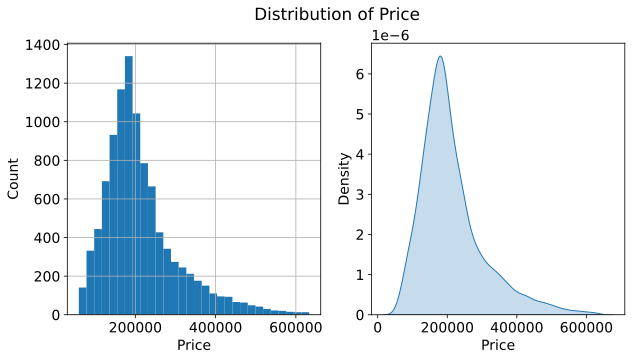

In [12]:
plt.figure(figsize = (10, 5))

plt.subplot(121)
train_df['Price'].hist(bins=30)
plt.ylabel('Сount')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

### Количественные переменные

In [13]:
train_df.describe()

Rooms        Square   LifeSquare  KitchenSquare         Floor  \
count  10000.000000  10000.000000  7887.000000   10000.000000  10000.000000   
mean       1.890500     56.315712    37.199596       6.273300      8.526700   
std        0.839523     21.058718    86.241112      28.561113      5.241148   
min        0.000000      1.136859     0.370619       0.000000      1.000000   
25%        1.000000     41.774879    22.769833       1.000000      4.000000   
50%        2.000000     52.513309    32.781261       6.000000      7.000000   
75%        2.000000     65.900627    45.128803       9.000000     12.000000   
max       19.000000    641.065186  7480.592285    2014.000000     42.000000   

         HouseFloor     HouseYear     Ecology_1      Social_1      Social_2  \
count  10000.000000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean      12.609400  3.990166e+03      0.118858     24.687000   5352.157400   
std        6.776192  2.005003e+05      0.119026     17.532614   4006.799803   
min        0.000000  1.910000e+03      0.000000      0.000000    168.000000   
25%        9.000000  1.974000e+03      0.017647      6.000000   1564.000000   
50%       13.000000  1.977000e+03      0.075424     25.000000   5285.000000   
75%       17.000000  2.001000e+03      0.195781     36.000000   7227.000000   
max      117.000000  2.005201e+07      0.521867     74.000000  19083.000000   

           Social_3  Healthcare_1   Helthcare_2       Shops_1          Price  
count  10000.000000   5202.000000  10000.000000  10000.000000   10000.000000  
mean       8.039200   1142.904419      1.319500      4.231300  214139.218750  
std       23.831875   1021.518982      1.493601      4.806341   92872.304688  
min        0.000000      0.000000      0.000000      0.000000   59174.777344  
25%        0.000000    350.000000      0.000000      1.000000  153872.628906  
50%        2.000000    900.000000      1.000000      3.000000  192269.648438  
75%        5.000000   1548.000000      2.000000      6.000000  249135.460938  
max      141.000000   4849.000000      6.000000     23.000000  633233.437500

In [14]:
df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16'])

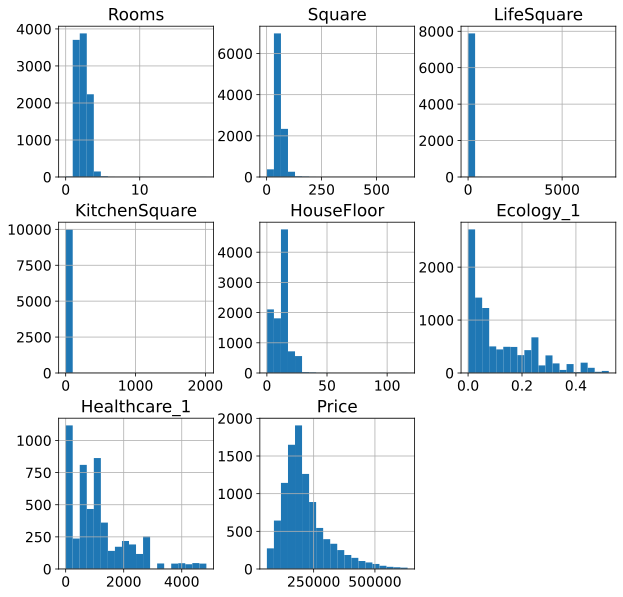

In [15]:
df_num_features.hist(figsize=(10,10), bins=20, grid=True);

### Категориальные переменные

In [16]:
cat_colnames = train_df.select_dtypes(include='category').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [17]:
for cat_colname in cat_colnames[2:]:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



In [18]:
for cat_colname in cat_colnames[2:]:
    print(train_df.groupby(cat_colname)['Price'].agg(['max', 'min', 'mean', 'median']))

                   max            min           mean         median
Ecology_2                                                          
A          480940.0625  108232.648438  193139.718750  182516.562500
B          633233.4375   59174.777344  214344.546875  192371.640625
                   max           min          mean        median
Ecology_3                                                       
A          624549.3750  84577.921875  243179.56250  211889.93750
B          633233.4375  59174.777344  213317.65625  191668.40625
                 max           min           mean      median
Shops_2                                                      
A        502523.5625  67343.132812  192339.703125  181620.000
B        633233.4375  59174.777344  216099.000000  193446.125


# Шаг 3. Очистка данных и feature engineering
## Обработка обучающего датасета (train.csv)

### Обработка выбросов

In [19]:
train_df.describe()

Rooms        Square   LifeSquare  KitchenSquare         Floor  \
count  10000.000000  10000.000000  7887.000000   10000.000000  10000.000000   
mean       1.890500     56.315712    37.199596       6.273300      8.526700   
std        0.839523     21.058718    86.241112      28.561113      5.241148   
min        0.000000      1.136859     0.370619       0.000000      1.000000   
25%        1.000000     41.774879    22.769833       1.000000      4.000000   
50%        2.000000     52.513309    32.781261       6.000000      7.000000   
75%        2.000000     65.900627    45.128803       9.000000     12.000000   
max       19.000000    641.065186  7480.592285    2014.000000     42.000000   

         HouseFloor     HouseYear     Ecology_1      Social_1      Social_2  \
count  10000.000000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean      12.609400  3.990166e+03      0.118858     24.687000   5352.157400   
std        6.776192  2.005003e+05      0.119026     17.532614   4006.799803   
min        0.000000  1.910000e+03      0.000000      0.000000    168.000000   
25%        9.000000  1.974000e+03      0.017647      6.000000   1564.000000   
50%       13.000000  1.977000e+03      0.075424     25.000000   5285.000000   
75%       17.000000  2.001000e+03      0.195781     36.000000   7227.000000   
max      117.000000  2.005201e+07      0.521867     74.000000  19083.000000   

           Social_3  Healthcare_1   Helthcare_2       Shops_1          Price  
count  10000.000000   5202.000000  10000.000000  10000.000000   10000.000000  
mean       8.039200   1142.904419      1.319500      4.231300  214139.218750  
std       23.831875   1021.518982      1.493601      4.806341   92872.304688  
min        0.000000      0.000000      0.000000      0.000000   59174.777344  
25%        0.000000    350.000000      0.000000      1.000000  153872.628906  
50%        2.000000    900.000000      1.000000      3.000000  192269.648438  
75%        5.000000   1548.000000      2.000000      6.000000  249135.460938  
max      141.000000   4849.000000      6.000000     23.000000  633233.437500

**Square, LifeSquare, KitchenSquare**

Найдем выбросы с помощью квантилей. Наблюдения, значения которых больше 99% квантиля и которые меньше 0,1% квантиля будем считать выбросами и удалим.

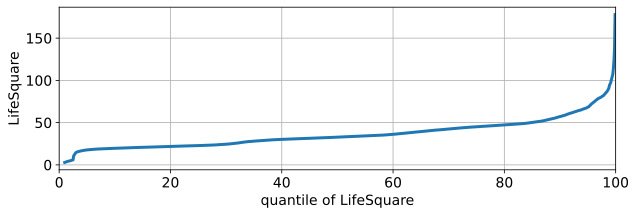

In [20]:
fig = plt.figure(figsize=(10, 3))
q = [np.percentile(train_df["LifeSquare"].dropna(), q=x) for x in np.arange(1, 100, 0.1)]
plt.plot(np.arange(1, 100, 0.1), q, linewidth=3)
plt.xlabel("quantile of LifeSquare", size=14)
plt.ylabel("LifeSquare", size=14)
plt.xlim(0, 100)
plt.grid()

In [21]:
LifeSquare_max_value = np.quantile(train_df['LifeSquare'].dropna(), q=0.99)
LifeSquare_max_value

95.65247192382814

In [22]:
LifeSquare_min_value = np.quantile(train_df['LifeSquare'].dropna(), q=0.01)
LifeSquare_min_value

2.861462788581848

In [23]:
condition_LifeSquare = train_df.loc[(train_df['LifeSquare'] > LifeSquare_max_value) | (train_df['LifeSquare'] < LifeSquare_min_value)].index

In [24]:
train_df.drop(condition_LifeSquare, axis=0, inplace=True)
train_df['LifeSquare'].describe()

count    7729.000000
mean       35.610016
std        15.476787
min         2.861966
25%        22.896866
50%        32.781261
75%        44.907505
max        95.645828
Name: LifeSquare, dtype: float64

In [25]:
KitchenSquare_max_value = np.quantile(train_df['KitchenSquare'].dropna(), q=0.99)
KitchenSquare_max_value

15.0

In [26]:
KitchenSquare_min_value = np.quantile(train_df['KitchenSquare'].dropna(), q=0.01) 
KitchenSquare_min_value 

0.0

In [27]:
condition_KitchenSquare = train_df.loc[(train_df['KitchenSquare'] > KitchenSquare_max_value) | (train_df['KitchenSquare'] < KitchenSquare_min_value)].index

In [28]:
train_df.drop(condition_KitchenSquare, axis=0, inplace=True)
train_df['KitchenSquare'].describe()

count    9748.000000
mean        5.645876
std         3.755826
min         0.000000
25%         1.000000
50%         6.000000
75%         9.000000
max        15.000000
Name: KitchenSquare, dtype: float64

In [29]:
Square_max_value = np.quantile(train_df['Square'].dropna(), q=0.99)
Square_max_value

107.0664159393313

In [30]:
Square_min_value = np.quantile(train_df['Square'].dropna(), q=0.01)
Square_min_value

29.720842571258544

In [31]:
condition_Square = train_df.loc[(train_df['Square'] > Square_max_value) | (train_df['Square'] < Square_min_value)].index

In [32]:
train_df.drop(condition_Square, axis=0, inplace=True)
train_df['Square'].describe()

count    9552.000000
mean       55.031086
std        16.075462
min        29.721867
25%        41.789598
50%        52.085157
75%        65.117550
max       106.867638
Name: Square, dtype: float64

In [33]:
train_df.describe()

Rooms       Square   LifeSquare  KitchenSquare        Floor  \
count  9552.000000  9552.000000  7501.000000    9552.000000  9552.000000   
mean      1.877722    55.031086    35.433525       5.662060     8.519786   
std       0.818937    16.075462    15.060360       3.733719     5.186141   
min       0.000000    29.721867     2.861966       0.000000     1.000000   
25%       1.000000    41.789598    23.023157       1.000000     4.000000   
50%       2.000000    52.085157    32.752586       6.000000     7.000000   
75%       2.000000    65.117550    44.606834       9.000000    12.000000   
max      19.000000   106.867638    95.645828      15.000000    42.000000   

        HouseFloor     HouseYear    Ecology_1     Social_1      Social_2  \
count  9552.000000  9.552000e+03  9552.000000  9552.000000   9552.000000   
mean     12.649602  4.083749e+03     0.119608    24.880967   5391.495603   
std       6.631191  2.051482e+05     0.119677    17.519822   4007.177859   
min       0.000000  1.914000e+03     0.000000     0.000000    168.000000   
25%       9.000000  1.973000e+03     0.017647     6.000000   1564.000000   
50%      14.000000  1.977000e+03     0.075779    25.000000   5285.000000   
75%      17.000000  1.999000e+03     0.195781    36.000000   7287.000000   
max     117.000000  2.005201e+07     0.521867    74.000000  19083.000000   

          Social_3  Healthcare_1  Helthcare_2      Shops_1          Price  
count  9552.000000   4990.000000  9552.000000  9552.000000    9552.000000  
mean      8.054544   1138.638672     1.322341     4.257014  211794.796875  
std      23.802050   1019.078674     1.484521     4.805112   88154.609375  
min       0.000000      0.000000     0.000000     0.000000   59174.777344  
25%       0.000000    350.000000     0.000000     1.000000  154300.046875  
50%       2.000000    900.000000     1.000000     3.000000  191811.460938  
75%       5.000000   1548.000000     2.000000     6.000000  247043.871094  
max     141.000000   4849.000000     6.000000    23.000000  633233.437500

Кухни меньше 3 м2, жилая площадь меньшу 10 м2 - это явно выбросы (соответственно общая площадь квартиры меньше 13 тоже выбросы). 
Соответственно, присвоим им:

In [34]:
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3 
train_df.loc[train_df['Square'] < 13, 'Square'] = 13 

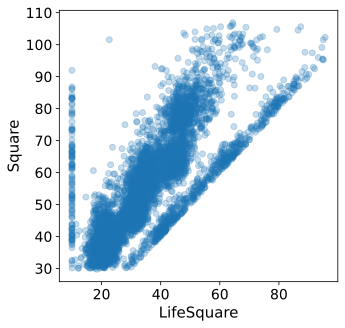

In [35]:
plt.figure(figsize=(5, 5))
plt.scatter(
   train_df[~((train_df['LifeSquare'] >= train_df['Square']))]['LifeSquare'], 
   train_df[~((train_df['LifeSquare'] >= train_df['Square']))]['Square'], alpha=0.25
)

plt.xlabel('LifeSquare', size=15)
plt.ylabel('Square', size=15)
plt.show()

Жилая площадь 10 м2 и общая площадь более 39 м2 мы будем считать выбросами. Возможно, это склады, но т.к. основной массив данных у нас для квартир, то примем, что склады вне области применимости модели. 

In [36]:
train_df.drop(train_df.loc[(train_df['LifeSquare'] == 10)&(train_df['Square'] >= 30)].index, axis=0, inplace=True) 

Теперь работает с данными, у которых сумма жилой площади и кухне больше общей площади квартиры

In [37]:
train_df[train_df["Square"] < train_df["KitchenSquare"] + train_df["LifeSquare"]]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
3      5809         58    2.0  53.352982   52.731510            9.0      8   
14    10953         27    1.0  53.769096   52.408028            3.0      5   
28     8054         23    1.0  42.530045   43.967758            3.0      3   
42     9833          1    2.0  56.494316   54.723568            3.0      9   
48     7596         23    1.0  47.080101   46.807991           12.0      3   
...     ...        ...    ...        ...         ...            ...    ...   
9903   4153         23    1.0  32.879524   30.397747            3.0      9   
9906  10189          6    1.0  39.894108   38.231625            3.0     15   
9951   9237         25    1.0  33.516312   31.086243            3.0     13   
9974   2159         30    1.0  33.227093   32.639168            3.0      4   
9983   2705          6    2.0  64.311707   61.920700            3.0     12   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
3           17.0       1977   0.437885         B         B        23   
14           4.0       1977   0.072158         B         B         2   
28           9.0       2014   0.034656         B         B         0   
42          17.0       1977   0.007122         B         B         1   
48           9.0       1977   0.014073         B         B         2   
...          ...        ...        ...       ...       ...       ...   
9903         9.0       2015   0.034656         B         B         0   
9906        17.0       2016   0.243205         B         B         5   
9951        11.0       2015   0.069753         B         B        53   
9974         4.0       2016   0.000078         B         B        22   
9983        17.0       2015   0.243205         B         B         5   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
3         5735         3        1084.0            0        5       B   
14         629         1           NaN            0        0       A   
28         168         0           NaN            0        0       B   
42         264         0           NaN            0        1       B   
48         475         0           NaN            0        0       B   
...        ...       ...           ...          ...      ...     ...   
9903       168         0           NaN            0        0       B   
9906      1564         0         540.0            0        0       B   
9951     13670         4           NaN            1       11       B   
9974      6398       141        1046.0            3       23       B   
9983      1564         0         540.0            0        0       B   

              Price  
3     175616.234375  
14    140647.562500  
28     95338.195312  
42    196078.906250  
48     96029.164062  
...             ...  
9903   70098.382812  
9906  129675.062500  
9951  148066.437500  
9974   65949.312500  
9983  164356.218750  

[963 rows x 20 columns]

Присвоим квартирам, у которых общая площадь меньше суммы жилой площади и площали кухни, само значение суммы жилой площади и площади кухни

In [38]:
train_df.loc[train_df["Square"] < train_df["KitchenSquare"] + train_df["LifeSquare"], 'Square'] = train_df.loc[train_df["Square"] < train_df["KitchenSquare"] + train_df["LifeSquare"], 'KitchenSquare'] + train_df.loc[train_df["Square"] < train_df["KitchenSquare"] + train_df["LifeSquare"], 'LifeSquare']

Проверяем, остались ли такие квартиры, у которых общая площадь меньше суммы площадей кухни и жилой части квартиры

In [39]:
train_df[train_df["Square"] < train_df["KitchenSquare"] + train_df["LifeSquare"]]

Empty DataFrame
Columns: [Id, DistrictId, Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Ecology_1, Ecology_2, Ecology_3, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1, Shops_2, Price]
Index: []

Теперь смотрим квартиры, у которых кухня больше жилой площади 

In [40]:
train_df[train_df['KitchenSquare'] >= train_df['LifeSquare']].shape

(2, 20)

Их немного, поэтому принимаем решение удалить их.

In [41]:
train_df.drop(train_df[train_df["KitchenSquare"] >= train_df["LifeSquare"]].index, axis=0, inplace=True)  
train_df[train_df["KitchenSquare"] > train_df["LifeSquare"]].shape

(0, 20)

In [42]:
train_df[train_df['KitchenSquare'] >= train_df['Square']].shape

(0, 20)

**HouseFloor, Floor** 

In [43]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [44]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  29.,  30.,  32.,  37.,  38.,
        39.,  40.,  44.,  45.,  48.,  99., 117.], dtype=float32)

Смотрим, сколько квартир, у которых отмечено, что у них нулевой этаж

In [45]:
train_df[(train_df['HouseFloor']==0)]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
7     11993         74    2.0  80.312927         NaN            3.0     14   
39     9371         23    2.0  60.503250         NaN            3.0     16   
65    11398         62    1.0  41.194187         NaN            3.0      6   
70    10362         27    2.0  79.227051         NaN            3.0      9   
195    4645         54    2.0  76.312851         NaN            3.0     14   
...     ...        ...    ...        ...         ...            ...    ...   
9707  12302         30    1.0  51.307846   48.307846            3.0      4   
9769   9384         59    3.0  98.607330         NaN            3.0     14   
9878  11441         62    2.0  75.453232   72.453232            3.0      5   
9908   3171         62    1.0  35.873962         NaN            3.0     25   
9944  16160         27    2.0  60.396767         NaN            3.0     10   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
7            0.0       1977   0.075779         B         B         6   
39           0.0       1977   0.034656         B         B         0   
65           0.0       1977   0.072158         B         B         2   
70           0.0       1977   0.072158         B         B         2   
195          0.0       1977   0.006076         B         B        30   
...          ...        ...        ...       ...       ...       ...   
9707         0.0       1977   0.000078         B         B        22   
9769         0.0       1977   0.019509         B         B        37   
9878         0.0       1977   0.072158         B         B         2   
9908         0.0       1977   0.072158         B         B         2   
9944         0.0       1977   0.072158         B         B         2   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
7         1437         3           NaN            0        2       B   
39         168         0           NaN            0        0       B   
65         629         1           NaN            0        0       A   
70         629         1           NaN            0        0       A   
195       5285         0         645.0            6        6       B   
...        ...       ...           ...          ...      ...     ...   
9707      6398       141        1046.0            3       23       B   
9769      7687        11         176.0            5        5       B   
9878       629         1           NaN            0        0       A   
9908       629         1           NaN            0        0       A   
9944       629         1           NaN            0        0       A   

             Price  
7     221244.15625  
39    229778.06250  
65    114063.09375  
70    167023.96875  
195   466730.81250  
...            ...  
9707  161403.09375  
9769  492700.25000  
9878  158841.62500  
9908  134379.12500  
9944  211810.59375  

[246 rows x 20 columns]

In [46]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median() #Заменять на медиану

Есть ли дома, у которых этаж квартиры больше количества этажей в доме

In [47]:
train_df[(train_df['Floor'] >= train_df['HouseFloor'])]

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
7     11993         74    2.0   80.312927         NaN            3.0     14   
14    10953         27    1.0   55.408028   52.408028            3.0      5   
16     2119         27    2.0   49.360649   31.993963            5.0      6   
21    11935         27    2.0   64.711838         NaN            3.0     15   
30       89         50    2.0   39.435352   23.377687            7.0      9   
...     ...        ...    ...         ...         ...            ...    ...   
9989   4145         96    3.0   90.055229   47.860229           11.0     26   
9991  11553          3    3.0  101.622795   51.628780           12.0     18   
9994   4158         23    2.0   64.864197         NaN            3.0     17   
9995     77         32    2.0   50.401787   30.476204            5.0      6   
9996   6159         18    1.0   41.521545   20.539215            9.0     13   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
7           14.0       1977   0.075779         B         B         6   
14           4.0       1977   0.072158         B         B         2   
16           5.0       1983   0.051815         B         B         5   
21           1.0       1977   0.211401         B         B         9   
30           9.0       1965   0.007659         B         B        35   
...          ...        ...        ...       ...       ...       ...   
9989        24.0       2005   0.041116         B         B        53   
9991        17.0       2000   0.265089         B         B        37   
9994        17.0       1977   0.075779         B         B         6   
9995         5.0       1968   0.135650         B         B        46   
9996        13.0       2000   0.000000         B         B        30   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
7         1437         3           NaN            0        2       B   
14         629         1           NaN            0        0       A   
16        1227         0           NaN            0        0       B   
21        1892         0           NaN            0        1       B   
30        7077        56        2301.0            3       19       B   
...        ...       ...           ...          ...      ...     ...   
9989     14892         4           NaN            1        4       B   
9991      5288         0        1937.0            3        2       B   
9994      1437         3           NaN            0        2       B   
9995      7960         6         350.0            3       11       B   
9996      5562         0           NaN            0        5       A   

              Price  
7     221244.156250  
14    140647.562500  
16    117000.382812  
21    127200.023438  
30    283877.625000  
...             ...  
9989  441108.906250  
9991  212883.500000  
9994  171323.515625  
9995  196684.312500  
9996  189050.296875  

[2308 rows x 20 columns]

In [48]:
floor_outliers = train_df[train_df['Floor'] > train_df['HouseFloor']].index

train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(
    lambda x: random.randint(1, x)
)

**HouseYear**

In [49]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
3485        2020
4493        2020
3357        2020
          ...   
5053        1917
1380        1917
8144        1917
7611        1916
910         1914
Name: HouseYear, Length: 9435, dtype: int32

In [50]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

**Rooms**

In [51]:
train_df['Rooms'].value_counts().sort_index()

0.0        5
1.0     3473
2.0     3760
3.0     2081
4.0      107
5.0        5
6.0        1
10.0       2
19.0       1
Name: Rooms, dtype: int64

In [52]:
stats_appt = train_df.groupby("Rooms").agg({'Square':['min', 'max', 'median']})
stats_appt = stats_appt.rename(columns={'min':'min_Square', 'max':'max_Square', 'mean':'mean_Square'})  
stats_appt.columns = stats_appt.columns.droplevel(0)
stats_appt.reset_index(inplace=True)
stats_appt

Rooms  min_Square  max_Square     median
0    0.0   38.697117   88.125473  49.483501
1    1.0   29.721867  106.514214  40.809971
2    2.0   33.468719  106.892128  55.833542
3    3.0   31.113951  106.867638  77.024063
4    4.0   44.128948  106.767677  94.164932
5    5.0   42.003292   95.617531  85.313606
6    6.0   59.414333   59.414333  59.414333
7   10.0   59.056976   60.871265  59.964119
8   19.0   42.006046   42.006046  42.006046

In [53]:
train_df.loc[(train_df['Rooms'] == 0)&(train_df['Square'] <= 42), 'Rooms'] = 1
train_df.loc[(train_df['Rooms'] == 0)&(train_df['Square'] <= 56)&(train_df['Square'] >= 40), 'Rooms'] = 2
train_df.loc[(train_df['Rooms'] == 0)&(train_df['Square'] <= 77)&(train_df['Square'] >= 98), 'Rooms'] = 3
train_df.loc[(train_df['Rooms'] == 0)&(train_df['Square'] > 77)&(train_df['Square'] <= 98), 'Rooms'] = 4
train_df.loc[(train_df['Rooms'] == 6)&(train_df['Square'] >= 56)&(train_df['Square'] <= 77), 'Rooms'] = 3
train_df.loc[(train_df['Rooms'] == 10)&(train_df['Square'] >= 56)&(train_df['Square'] <= 77), 'Rooms'] = 3
train_df.loc[(train_df['Rooms'] == 19), 'Rooms'] = 2

In [54]:
train_df['Rooms'].value_counts().sort_index()

1.0    3475
2.0    3762
3.0    2084
4.0     109
5.0       5
Name: Rooms, dtype: int64

### Обработка пропусков

In [55]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2051
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4510
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

**LifeSquare**

In [56]:
mask = train_df.loc[:, ['LifeSquare', 'Square']]

In [57]:
mask.corr()

LifeSquare   Square
LifeSquare     1.00000  0.84123
Square         0.84123  1.00000

In [58]:
mask = mask.dropna()
lr_square = LinearRegression()
lr_square.fit(mask['LifeSquare'].values.reshape(-1, 1), mask['Square'])

LinearRegression()

In [59]:
lr_square.score(mask['LifeSquare'].values.reshape(-1, 1), mask['Square'])

0.7076671087222897

In [60]:
train_df.loc[(train_df['LifeSquare'].isna()), 'LifeSquare'] = train_df.loc[(train_df['LifeSquare'].isna()), 'Square']*lr_square.coef_[0] + lr_square.intercept_

In [61]:
print(f'We will use linear equation: y = {lr_square.coef_[0]}*x + {lr_square.intercept_} to estimate LifeSquare from Square')

We will use linear equation: y = 0.9206745624542236*x + 21.48095703125 to estimate LifeSquare from Square


In [62]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4510
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

**Healthcare_1**

In [63]:
train_df['Healthcare_1'].value_counts()

540.0     465
30.0      321
1046.0    224
750.0     159
229.0     144
         ... 
2500.0     12
920.0      10
1815.0     10
35.0        2
0.0         1
Name: Healthcare_1, Length: 79, dtype: int64

In [64]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

Проверяем - остались ли пропуски

In [65]:
train_df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [66]:
train_df.shape

(9435, 20)

## Обработка тестового датасета (test.csv) - по аналогии с обучающим датасетом (train.csv)
### Обработка выбросов

In [67]:
test_df.describe()

Id   DistrictId        Rooms       Square   LifeSquare  \
count   5000.000000  5000.000000  5000.000000  5000.000000  3959.000000   
mean    8412.595400    51.279200     1.910000    56.449500    36.158810   
std     4832.674037    44.179466     0.838594    19.092787    17.825287   
min        1.000000     0.000000     0.000000     1.378543     0.333490   
25%     4221.750000    21.000000     1.000000    41.906231    23.092026   
50%     8320.500000    37.000000     2.000000    52.921340    32.925087   
75%    12598.250000    77.000000     2.000000    66.285129    45.174091   
max    16795.000000   212.000000    17.000000   223.453689   303.071094   

       KitchenSquare        Floor   HouseFloor    HouseYear    Ecology_1  \
count    5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean        5.976800     8.632000    12.601000  1984.392600     0.119874   
std         9.950018     5.483228     6.789213    18.573149     0.120070   
min         0.000000     1.000000     0.000000  1908.000000     0.000000   
25%         1.000000     4.000000     9.000000  1973.000000     0.019509   
50%         6.000000     7.000000    12.000000  1977.000000     0.072158   
75%         9.000000    12.000000    17.000000  2000.000000     0.195781   
max       620.000000    78.000000    99.000000  2020.000000     0.521867   

          Social_1      Social_2     Social_3  Healthcare_1  Helthcare_2  \
count  5000.000000   5000.000000  5000.000000   2623.000000   5000.00000   
mean     24.933800   5406.900000     8.262600   1146.657263      1.31940   
std      17.532202   4026.614773    23.863762   1044.744231      1.47994   
min       0.000000    168.000000     0.000000      0.000000      0.00000   
25%       6.000000   1564.000000     0.000000    325.000000      0.00000   
50%      25.000000   5285.000000     2.000000    900.000000      1.00000   
75%      36.000000   7287.000000     5.000000   1548.000000      2.00000   
max      74.000000  19083.000000   141.000000   4849.000000      6.00000   

           Shops_1  
count  5000.000000  
mean      4.242800  
std       4.777365  
min       0.000000  
25%       1.000000  
50%       3.000000  
75%       6.000000  
max      23.000000

In [68]:
test_df.loc[test_df['LifeSquare'] < 10, 'LifeSquare'] = 10
test_df.loc[test_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3 
test_df.loc[test_df['Square'] < 13, 'Square'] = 13 

In [69]:
test_df[test_df["Square"] < test_df["KitchenSquare"] + test_df["LifeSquare"]]

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
2      5480         190    1.0  13.597819   15.948246           12.0      2   
27    11160          58    1.0  48.610661   48.752502            3.0      4   
29      891          85    2.0  65.550690   61.689280           10.0     13   
39     6624          27    1.0  42.413793   42.434887           10.0     12   
43    11513           1    1.0  37.484057   40.593036            3.0      4   
...     ...         ...    ...        ...         ...            ...    ...   
4969   4821          74    2.0  82.542507   82.585069            3.0      4   
4972  16064          30    1.0  38.376234   37.003311            3.0      2   
4974   5296          52    1.0  44.442218   44.634608            3.0      5   
4979  14090           2    1.0  39.082641   33.214358            7.0     10   
4982  12920          23    1.0  39.610426   38.187571            3.0      6   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
2            5.0       1909   0.000000         B         B        30   
27           3.0       1977   0.437885         B         B        23   
29          22.0       1988   0.037178         B         B        52   
39          17.0       2017   0.011654         B         B         4   
43          17.0       1977   0.007122         B         B         1   
...          ...        ...        ...       ...       ...       ...   
4969        17.0       2015   0.309479         B         B        35   
4972         1.0       1977   0.000078         B         B        22   
4974        17.0       1977   0.371149         B         B        34   
4979        14.0       1970   0.000000         B         B        33   
4982        18.0       2013   0.034656         B         B         0   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
2         7538        87        4702.0            5        5       B  
27        5735         3        1084.0            0        5       B  
29       11217         1        2300.0            1        7       B  
39         915         0           NaN            0        0       B  
43         264         0           NaN            0        1       B  
...        ...       ...           ...          ...      ...     ...  
4969      7715         4         990.0            0        6       B  
4972      6398       141        1046.0            3       23       B  
4974      7065         1         750.0            2        5       B  
4979      7425         1           NaN            2        5       B  
4982       168         0           NaN            0        0       B  

[552 rows x 19 columns]

Применим

In [70]:
test_df.loc[test_df["Square"] < test_df["KitchenSquare"] + test_df["LifeSquare"], 'Square'] = test_df.loc[test_df["Square"] < test_df["KitchenSquare"] + test_df["LifeSquare"], 'KitchenSquare'] + test_df.loc[test_df["Square"] < test_df["KitchenSquare"] + test_df["LifeSquare"], 'LifeSquare']

In [71]:
test_df[test_df["Square"] < test_df["KitchenSquare"] + test_df["LifeSquare"]]

Empty DataFrame
Columns: [Id, DistrictId, Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Ecology_1, Ecology_2, Ecology_3, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1, Shops_2]
Index: []

In [72]:
test_df[test_df['KitchenSquare'] >= test_df['LifeSquare']]

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
1456   5260          73    3.0  116.247581   51.247581           65.0      6   
1964  14594          11    2.0  644.223770   24.223770          620.0     11   
2424  10662          29    1.0   50.251768   17.251768           33.0      5   
3816  12612          27    2.0   93.646726   33.646726           60.0      5   
3863   3194          29    2.0   75.028707   31.028707           44.0      6   
4281   8015          27    1.0   95.639611   33.639611           62.0      3   
4546   5254         186    2.0   88.618122   25.457811           30.0      5   
4555  12640           6    2.0  128.486308   31.486308           97.0      4   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1456         6.0       1931   0.042032         B         B        37   
1964        14.0       1972   0.038693         B         B        28   
2424         5.0       1973   0.069660         B         B        31   
3816        17.0       2013   0.072158         B         B         2   
3863         5.0       1964   0.086885         B         B        10   
4281         7.0       2016   0.014058         B         B         1   
4546        19.0       1985   0.007659         B         B        35   
4555        17.0       2015   0.243205         B         B         5   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
1456      6856        84        1940.0            2        5       B  
1964      6533         1        1015.0            2        5       B  
2424      6119         4           NaN            1        2       B  
3816       629         1           NaN            0        0       A  
3863      2277         2        1547.0            0        0       B  
4281       290         0           NaN            0        0       B  
4546      7077        56        2301.0            3       19       B  
4555      1564         0         540.0            0        0       B

In [73]:
test_df.loc[test_df['KitchenSquare'] >= test_df['LifeSquare'], 'KitchenSquare'] = test_df['KitchenSquare'].median() 

In [74]:
test_df[test_df['KitchenSquare'] >= test_df['LifeSquare']]

Empty DataFrame
Columns: [Id, DistrictId, Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Ecology_1, Ecology_2, Ecology_3, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1, Shops_2]
Index: []

**HouseFloor, Floor** 

In [75]:
test_df[(test_df['HouseFloor']==0)]

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
22    12694          27    3.0  83.670032   46.358356            3.0      8   
24     8968          27    2.0  69.849239         NaN            3.0      3   
30     2982           6    2.0  63.460684         NaN            3.0     13   
32     2449           1    1.0  66.426585         NaN            3.0     14   
46    12309          45    1.0  42.899569         NaN            3.0     25   
...     ...         ...    ...        ...         ...            ...    ...   
4856  10262          27    2.0  69.196440         NaN            3.0     10   
4887  12116          88    3.0  89.549559         NaN            3.0     20   
4892  16357          58    1.0  49.205978         NaN            3.0      4   
4976   4723          95    1.0  45.542940         NaN            3.0      6   
4998   4780          62    2.0  81.305222         NaN            3.0      4   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
22           0.0       2015   0.072158         B         B         2   
24           0.0       1977   0.011654         B         B         4   
30           0.0       1977   0.243205         B         B         5   
32           0.0       1977   0.007122         B         B         1   
46           0.0       1977   0.195781         B         B        23   
...          ...        ...        ...       ...       ...       ...   
4856         0.0       1977   0.017647         B         B         2   
4887         0.0       1977   0.127376         B         B        43   
4892         0.0       1977   0.437885         B         B        23   
4976         0.0       1977   0.000699         B         B        14   
4998         0.0       1977   0.072158         B         B         2   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
22         629         1           NaN            0        0       A  
24         915         0           NaN            0        0       B  
30        1564         0         540.0            0        0       B  
32         264         0           NaN            0        1       B  
46        5212         6           NaN            3        2       B  
...        ...       ...           ...          ...      ...     ...  
4856       469         0           NaN            0        0       B  
4887      8429         3           NaN            3        9       B  
4892      5735         3        1084.0            0        5       B  
4976      3369        24        4129.0            0        3       B  
4998       629         1           NaN            0        0       A  

[131 rows x 19 columns]

In [76]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = test_df['HouseFloor'].median() 

In [77]:
test_df[(test_df['Floor'] >= test_df['HouseFloor'])]

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
1     15856          74    2.0  69.263183         NaN            3.0      6   
3     15664          47    2.0  73.046609   51.940842            9.0     22   
4     14275          27    1.0  47.527111   43.387569            3.0     17   
5      7633          53    1.0  40.675627         NaN            3.0     21   
8      4220          96    3.0  72.277106   45.968758            9.0     17   
...     ...         ...    ...        ...         ...            ...    ...   
4981   2560           8    2.0  47.488384   28.896493            6.0      5   
4983   8249          58    1.0  39.768340   22.413943            8.0     10   
4989   2591          39    2.0  44.203592   30.191691            6.0     10   
4993  14562         113    2.0  46.627882   27.058739            5.0      6   
4997   5783          12    3.0  77.842178   48.282625            9.0     23   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1            1.0       1977   0.075779         B         B         6   
3           22.0       2007   0.101872         B         B        23   
4           17.0       2017   0.072158         B         B         2   
5           21.0       1977   0.049637         B         B        34   
8           17.0       1997   0.041116         B         B        53   
...          ...        ...        ...       ...       ...       ...   
4981         5.0       1963   0.437885         B         B        23   
4983        10.0       2005   0.310199         B         B        11   
4989         9.0       1972   0.428826         B         B        25   
4993         5.0       1969   0.307467         B         A        30   
4997        22.0       1989   0.090799         B         B        74   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
1         1437         3           NaN            0        2       B  
3         4583         3           NaN            3        3       B  
4          629         1           NaN            0        0       A  
5         7759         0         229.0            1        3       B  
8        14892         4           NaN            1        4       B  
...        ...       ...           ...          ...      ...     ...  
4981      5735         3        1084.0            0        5       B  
4983      2748         1           NaN            0        0       B  
4989      5011         8         730.0            0        2       B  
4993      5048         9         325.0            2        5       B  
4997     19083         2           NaN            5       15       B  

[1304 rows x 19 columns]

In [78]:
floor_outliers = test_df[test_df['Floor'] > test_df['HouseFloor']].index

test_df.loc[floor_outliers, 'Floor'] = test_df.loc[floor_outliers, 'HouseFloor'].apply(
    lambda x: random.randint(1, x)
)

**Rooms**

In [79]:
test_df['Rooms'].value_counts().sort_index()

0.0        2
1.0     1769
2.0     2030
3.0     1099
4.0       90
5.0        7
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [80]:
stats_appt_test = test_df.groupby("Rooms").agg({'Square':['min', 'max', 'median']})
stats_appt_test = stats_appt_test.rename(columns={'min':'min_Square', 'max':'max_Square', 'mean':'mean_Square'})  
stats_appt_test.columns = stats_appt_test.columns.droplevel(0)
stats_appt_test.reset_index(inplace=True)
stats_appt_test

Rooms  min_Square  max_Square      median
0    0.0   76.345154  116.824201   96.584677
1    1.0   13.000000  163.325901   40.446743
2    2.0   33.882914  644.223770   56.294047
3    3.0   40.674037  224.247841   77.937598
4    4.0   37.920348  189.679576   95.144246
5    5.0   56.600162  157.976101  120.330727
6    6.0  110.750226  223.453689  167.101957
7   17.0   52.866107   52.866107   52.866107

In [81]:
test_df.loc[(test_df['Rooms'] == 0), 'Rooms'] = 3
test_df.loc[(test_df['Rooms'] == 17), 'Rooms'] = 2

### Обработка пропусков

In [82]:
test_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

#### LifeSquare
Пропуски заполняются с помощью линейной регрессии, которая была получена по train датасету

In [83]:
test_df.loc[(test_df['LifeSquare'].isna()), 'LifeSquare'] = test_df.loc[(test_df['LifeSquare'].isna()), 'Square']*lr_square.coef_[0] + lr_square.intercept_

#### Healthcare_1

In [84]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

In [85]:
test_id = test_df['Id'].tolist()

In [86]:
test_df.shape

(5000, 19)

In [87]:
test_df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

In [88]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

### Построение новых признаков

**Dummies**

In [89]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

**DistrictSize**

In [90]:
train_df.head()

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038         35    2.0  47.981560   29.442751            6.0      7   
1  15053         41    3.0  65.683640   40.049541            8.0      7   
2   4765         53    2.0  44.947952   29.197611            3.0      8   
3   5809         58    2.0  61.731510   52.731510            9.0      8   
4  10783         99    1.0  39.649193   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1  ... Social_2 Social_3  Healthcare_1  \
0         9.0       1969   0.089040  ...     7976        5         900.0   
1         9.0       1978   0.000070  ...    10309        1         240.0   
2        12.0       1968   0.049637  ...     7759        0         229.0   
3        17.0       1977   0.437885  ...     5735        3        1084.0   
4        12.0       1976   0.012339  ...     5776        1        2078.0   

   Helthcare_2  Shops_1  Shops_2          Price  Ecology_2_bin Ecology_3_bin  \
0            0       11        B  184966.937500              1             1   
1            1       16        B  300009.437500              1             1   
2            1        3        B  220925.906250              1             1   
3            0        5        B  175616.234375              1             1   
4            2        4        B  150226.531250              1             1   

   Shops_2_bin  
0            1  
1            1  
2            1  
3            1  
4            1  

[5 rows x 23 columns]

In [91]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

DistrictId  DistrictSize
0         27           768
1          1           634
2         23           513
3          6           465
4          9           271

In [92]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')

train_df

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0     14038         35    2.0  47.981560   29.442751            6.0      7   
1     15053         41    3.0  65.683640   40.049541            8.0      7   
2      4765         53    2.0  44.947952   29.197611            3.0      8   
3      5809         58    2.0  61.731510   52.731510            9.0      8   
4     10783         99    1.0  39.649193   23.776169            7.0     11   
...     ...        ...    ...        ...         ...            ...    ...   
9430     77         32    2.0  50.401787   30.476204            5.0      1   
9431   6159         18    1.0  41.521545   20.539215            9.0     13   
9432   5123         27    1.0  47.939007   65.617180            3.0     12   
9433   5400         75    2.0  43.602562   33.840149            8.0      1   
9434   6306        128    1.0  38.666645   21.157875            8.0      7   

      HouseFloor  HouseYear  Ecology_1  ... Social_3 Healthcare_1  \
0            9.0       1969   0.089040  ...        5        900.0   
1            9.0       1978   0.000070  ...        1        240.0   
2           12.0       1968   0.049637  ...        0        229.0   
3           17.0       1977   0.437885  ...        3       1084.0   
4           12.0       1976   0.012339  ...        1       2078.0   
...          ...        ...        ...  ...      ...          ...   
9430         5.0       1968   0.135650  ...        6        350.0   
9431        13.0       2000   0.000000  ...        0        900.0   
9432        16.0       2015   0.072158  ...        1        900.0   
9433         5.0       1961   0.307467  ...        9        325.0   
9434        17.0       1990   0.000000  ...        0         30.0   

      Helthcare_2  Shops_1  Shops_2          Price  Ecology_2_bin  \
0               0       11        B  184966.937500              1   
1               1       16        B  300009.437500              1   
2               1        3        B  220925.906250              1   
3               0        5        B  175616.234375              1   
4               2        4        B  150226.531250              1   
...           ...      ...      ...            ...            ...   
9430            3       11        B  196684.312500              1   
9431            0        5        A  189050.296875              1   
9432            0        0        A  159143.812500              1   
9433            2        5        B  181595.343750              1   
9434            2        8        B  218714.078125              1   

      Ecology_3_bin Shops_2_bin  DistrictSize  
0                 1           1            22  
1                 1           1            85  
2                 1           1           170  
3                 1           1           173  
4                 1           1            95  
...             ...         ...           ...  
9430              1           1            32  
9431              1           0            51  
9432              1           0           768  
9433              0           1            64  
9434              1           1            64  

[9435 rows x 24 columns]

In [93]:
train_df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
Ecology_2_bin    0
Ecology_3_bin    0
Shops_2_bin      0
DistrictSize     0
dtype: int64

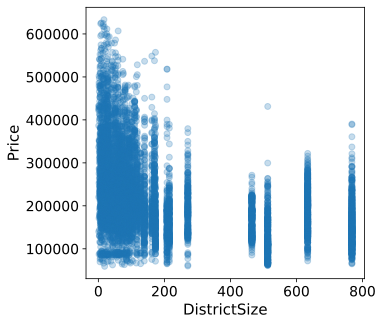

In [94]:
plt.figure(figsize=(5, 5))
plt.scatter(
    train_df["DistrictSize"], train_df["Price"], alpha=0.25
)
plt.xlabel("DistrictSize", size=15)
plt.ylabel("Price", size=15)
plt.show()

**MedPriceByDistrict**

In [95]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms']).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'}).dropna().reset_index()

med_price_by_district

DistrictId  Rooms  MedPriceByDistrict
0            0    1.0       147258.734375
1            0    2.0       176210.812500
2            0    3.0       300610.375000
3            1    1.0       146271.156250
4            1    2.0       202352.609375
..         ...    ...                 ...
636         98    3.0       245090.015625
637         98    4.0       450946.468750
638         99    1.0       158791.015625
639         99    2.0       187254.718750
640         99    3.0       225081.531250

[641 rows x 3 columns]

In [96]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038         35    2.0  47.981560   29.442751            6.0      7   
1  15053         41    3.0  65.683640   40.049541            8.0      7   
2   4765         53    2.0  44.947952   29.197611            3.0      8   
3   5809         58    2.0  61.731510   52.731510            9.0      8   
4  10783         99    1.0  39.649193   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1  ... Healthcare_1 Helthcare_2  Shops_1  \
0         9.0       1969   0.089040  ...        900.0           0       11   
1         9.0       1978   0.000070  ...        240.0           1       16   
2        12.0       1968   0.049637  ...        229.0           1        3   
3        17.0       1977   0.437885  ...       1084.0           0        5   
4        12.0       1976   0.012339  ...       2078.0           2        4   

   Shops_2          Price  Ecology_2_bin  Ecology_3_bin  Shops_2_bin  \
0        B  184966.937500              1              1            1   
1        B  300009.437500              1              1            1   
2        B  220925.906250              1              1            1   
3        B  175616.234375              1              1            1   
4        B  150226.531250              1              1            1   

  DistrictSize  MedPriceByDistrict  
0           22       207786.125000  
1           85       297041.125000  
2          170       262315.093750  
3          173       166809.671875  
4           95       158791.015625  

[5 rows x 25 columns]

*Пример переноса признака на test*

In [97]:
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [98]:
test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   int64  
 1   DistrictId          5000 non-null   object 
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          5000 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   object 
 11  Ecology_3           5000 non-null   object 
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Healthcare_1        5000 non-null   float64
 16  Helthc

In [99]:
test_df = pd.merge(test_df, med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

In [100]:
test_df = pd.merge(test_df, district_size, on='DistrictId', how='left')

test_df

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0       725         58    2.0  49.882643   33.432782            6.0      6   
1     15856         74    2.0  69.263183   85.249808            3.0      1   
2      5480        190    1.0  27.948246   15.948246           12.0      2   
3     15664         47    2.0  73.046609   51.940842            9.0     22   
4     14275         27    1.0  47.527111   43.387569            3.0     17   
...     ...        ...    ...        ...         ...            ...    ...   
4995   8180         11    3.0  67.133911   50.809797            6.0      5   
4996   4695          1    1.0  40.198472   21.807061           10.0     12   
4997   5783         12    3.0  77.842178   48.282625            9.0     18   
4998   4780         62    2.0  81.305222   96.336607            3.0      4   
4999  12504         30    2.0  60.555693   77.233043            3.0     10   

      HouseFloor  HouseYear  Ecology_1  ... Social_3 Healthcare_1  \
0           14.0       1972   0.310199  ...        1        900.0   
1            1.0       1977   0.075779  ...        3        900.0   
2            5.0       1909   0.000000  ...       87       4702.0   
3           22.0       2007   0.101872  ...        3        900.0   
4           17.0       2017   0.072158  ...        1        900.0   
...          ...        ...        ...  ...      ...          ...   
4995         9.0       1973   0.000170  ...        0        900.0   
4996        17.0       2017   0.007122  ...        0        900.0   
4997        22.0       1989   0.090799  ...        2        900.0   
4998        12.0       1977   0.072158  ...        1        900.0   
4999        17.0       1977   0.000078  ...      141       1046.0   

      Helthcare_2  Shops_1  Shops_2  Ecology_2_bin  Ecology_3_bin  \
0               0        0        B              1              1   
1               0        2        B              1              1   
2               5        5        B              1              1   
3               3        3        B              1              1   
4               0        0        A              1              1   
...           ...      ...      ...            ...            ...   
4995            1        1        B              1              1   
4996            0        1        B              1              1   
4997            5       15        B              1              1   
4998            0        0        A              1              1   
4999            3       23        B              1              1   

      Shops_2_bin MedPriceByDistrict  DistrictSize  
0               1      166809.671875         173.0  
1               1      243031.687500         101.0  
2               1                NaN           7.0  
3               1      222227.593750          97.0  
4               0      119459.023438         768.0  
...           ...                ...           ...  
4995            1      247249.093750         128.0  
4996            1      146271.156250         634.0  
4997            1      315198.843750          64.0  
4998            0      180325.765625         215.0  
4999            1      180773.796875         208.0  

[5000 rows x 24 columns]

In [101]:
test_df.loc[test_df['DistrictSize'].isnull(), ['DistrictSize', 'Rooms', 'DistrictId']] 

DistrictSize  Rooms DistrictId
51             NaN    2.0        212
1043           NaN    2.0        210
1475           NaN    4.0        206
2323           NaN    3.0        204
2370           NaN    2.0        203
2666           NaN    2.0        211
3668           NaN    2.0        206
4046           NaN    2.0        198

In [102]:
test_df.isna().sum()

Id                     0
DistrictId             0
Rooms                  0
Square                 0
LifeSquare             0
KitchenSquare          0
Floor                  0
HouseFloor             0
HouseYear              0
Ecology_1              0
Ecology_2              0
Ecology_3              0
Social_1               0
Social_2               0
Social_3               0
Healthcare_1           0
Helthcare_2            0
Shops_1                0
Shops_2                0
Ecology_2_bin          0
Ecology_3_bin          0
Shops_2_bin            0
MedPriceByDistrict    77
DistrictSize           8
dtype: int64

In [103]:
test_df.loc[test_df['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = test_df['MedPriceByDistrict'].median()

In [104]:
test_df.loc[test_df['DistrictSize'].isnull(), 'DistrictSize'] = test_df['DistrictSize'].median()

**med_price_by_floor**

In [105]:
med_price_by_floor = train_df.groupby(['HouseYear', 'Floor']).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByFloor'}).dropna().reset_index()

med_price_by_floor

HouseYear  Floor  MedPriceByFloor
0          1914      3    423580.468750
1          1916      4    284608.937500
2          1917      2     69623.750000
3          1917      3    236830.765625
4          1917      5    486057.125000
...         ...    ...              ...
1163       2020     11    263206.218750
1164       2020     13    283334.500000
1165       2020     14    266202.156250
1166       2020     15    242243.093750
1167       2020     19    441850.468750

[1168 rows x 3 columns]

In [106]:
train_df = train_df.merge(med_price_by_floor, on=['HouseYear', 'Floor'], how='left')
train_df.head()

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038         35    2.0  47.981560   29.442751            6.0      7   
1  15053         41    3.0  65.683640   40.049541            8.0      7   
2   4765         53    2.0  44.947952   29.197611            3.0      8   
3   5809         58    2.0  61.731510   52.731510            9.0      8   
4  10783         99    1.0  39.649193   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1  ... Helthcare_2 Shops_1  Shops_2  \
0         9.0       1969   0.089040  ...           0      11        B   
1         9.0       1978   0.000070  ...           1      16        B   
2        12.0       1968   0.049637  ...           1       3        B   
3        17.0       1977   0.437885  ...           0       5        B   
4        12.0       1976   0.012339  ...           2       4        B   

           Price  Ecology_2_bin  Ecology_3_bin  Shops_2_bin  DistrictSize  \
0  184966.937500              1              1            1            22   
1  300009.437500              1              1            1            85   
2  220925.906250              1              1            1           170   
3  175616.234375              1              1            1           173   
4  150226.531250              1              1            1            95   

  MedPriceByDistrict  MedPriceByFloor  
0      207786.125000    208777.125000  
1      297041.125000    235078.031250  
2      262315.093750    200377.734375  
3      166809.671875    169911.593750  
4      158791.015625    188660.343750  

[5 rows x 26 columns]

In [107]:
test_df.merge(med_price_by_floor, on=['HouseYear', 'Floor'], how='left').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   int64  
 1   DistrictId          5000 non-null   object 
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          5000 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   object 
 11  Ecology_3           5000 non-null   object 
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Healthcare_1        5000 non-null   float64
 16  Helthc

In [108]:
test_df = pd.merge(test_df, med_price_by_floor, on=['HouseYear', 'Floor'], how='left')

In [109]:
test_df.loc[test_df['MedPriceByFloor'].isnull(), 'MedPriceByFloor'] = test_df['MedPriceByFloor'].median()

In [110]:
test_df.isna().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Healthcare_1          0
Helthcare_2           0
Shops_1               0
Shops_2               0
Ecology_2_bin         0
Ecology_3_bin         0
Shops_2_bin           0
MedPriceByDistrict    0
DistrictSize          0
MedPriceByFloor       0
dtype: int64

## Оставим признаки, которые необходимы для модели

In [111]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'MedPriceByDistrict',
 'MedPriceByFloor']

In [112]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['DistrictSize', 'MedPriceByDistrict', 'MedPriceByFloor']
target_name = 'Price'

### Сохранение  датасета

In [113]:
train_df.to_csv('./project_task/train_prepared.csv', index=False, encoding='utf-8', sep=',')
test_df.to_csv('./project_task/test_prepared.csv', index=False, encoding='utf-8', sep=',')
train_df = pd.read_csv('./project_task/train_prepared.csv')

# Шаг 4. Разбиение на train / test

In [114]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [115]:
# Кросс-валидацию KFold, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=21)

In [116]:
X_train.columns

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1',
       'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1',
       'Shops_2_bin', 'DistrictSize', 'MedPriceByDistrict', 'MedPriceByFloor'],
      dtype='object')

In [117]:
y_train = y_train.apply(lambda x: np.log(x))
y_test = y_test.apply(lambda x: np.log(x))

# Шаг 5. Построение модели
## Gradient Boosting decision trees 

**GridSearchCV GB**

In [118]:
#%%time
#params = {'n_estimators':[100, 200, 400, 1000], 
 #         'max_depth':[3, 5, 7, 10]}

#gs = GridSearchCV(gb_model, params, 
 #                 scoring='r2', # метрика 
  #                cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
   #                        random_state=21, 
    #                       shuffle=True),
     #             n_jobs=-1
      #            )
#gs.fit(X_train, y_train)

In [119]:
#gs.best_params_

In [120]:
#gs.best_score_

**Настройка и оценка финальной модели** - 

In [121]:
final_model_gb = GradientBoostingRegressor(criterion='mse',
                                        max_depth=5,
                                        n_estimators=100,
                                        random_state = 21)

final_model_gb.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, random_state=21)

Train R2:	0.839
Test R2:	0.727


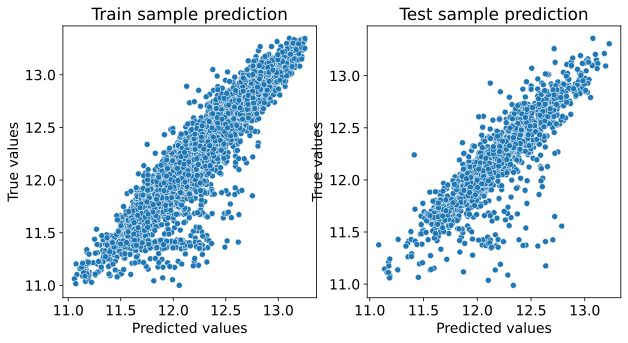

In [122]:
y_train_preds = final_model_gb.predict(X_train)
y_test_preds = final_model_gb.predict(X_test)
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

**Кросс-валидация**

In [123]:
cv_score = cross_val_score(
    final_model_gb,
    X,
    y,
    scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=21)
)
cv_score

array([0.77148197, 0.7607305 , 0.77608005, 0.79022931, 0.76647145])

In [124]:
cv_score.mean(), cv_score.std()

(0.772998655283842, 0.010018010578107682)

In [125]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.7629806447057343, 0.7830166658619497)

**Важность признаков**

In [126]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model_gb.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

feature_name  importance
18  MedPriceByDistrict    0.715471
19     MedPriceByFloor    0.076227
1               Square    0.070490
2           LifeSquare    0.019668
11            Social_2    0.015767
17        DistrictSize    0.015698
10            Social_1    0.013351
5           HouseFloor    0.013328
7            Ecology_1    0.012686
3        KitchenSquare    0.010640
12            Social_3    0.008752
6            HouseYear    0.008451
13        Healthcare_1    0.006690
4                Floor    0.004869
0                Rooms    0.002996
15             Shops_1    0.002411
14         Helthcare_2    0.001378
16         Shops_2_bin    0.000772
8        Ecology_2_bin    0.000291
9        Ecology_3_bin    0.000065

# Шаг 5. Прогнозирование на тестовом датасете

In [127]:
X.columns

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1',
       'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1',
       'Shops_2_bin', 'DistrictSize', 'MedPriceByDistrict', 'MedPriceByFloor'],
      dtype='object')

In [128]:
test_df.shape

(5000, 25)

In [129]:
test_df = test_df.loc[:, X.columns]

In [130]:
test_df.columns

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1',
       'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1',
       'Shops_2_bin', 'DistrictSize', 'MedPriceByDistrict', 'MedPriceByFloor'],
      dtype='object')

### GB Model

In [131]:
predictions_gb = final_model_gb.predict(test_df)
predictions_gb

array([12.00211381, 12.4527755 , 12.18222102, ..., 12.66612008,
       12.12315146, 12.07563075])

In [132]:
pred_gb = pd.DataFrame(index=range(0, 5000), columns=['Id', 'Price'])
pred_gb['Id'] = test_id
pred_gb['Price'] = predictions_gb

In [133]:
pred_gb.to_csv('Millionshchikova_predictions.csv', index=False)

# Шаг 6. Сохранение модели 

In [134]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model_gb, file)